# Model Building

In [13]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

from scipy import stats

pd.set_option('display.max_columns', None)
import seaborn as sn
import numpy as np
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

## Data processed

In [2]:
data = pd.read_pickle('\..\Data\processed\data_preprocessed.pkl')

In [4]:
weather = pd.read_csv('\..\Data\external\data_weather_2017.csv')
weather = weather[['DATE','AWND','PRCP','SNOW','SNWD','TMAX','TMIN']]
weather['TAVG'] = (weather['TMAX']+weather['TMIN'])/2
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather = weather.drop(columns=['TMAX','TMIN'])
data['date'] = data['tpep_pickup_datetime'].dt.normalize()
data = pd.merge(data, weather, left_on='date', right_on='DATE').drop('DATE', axis=1)

## Correlation

We are going to investigate the correlation between continuous variables. On the one hand, as we can see in the image, the correlation coefficient between attributes like fare amount, tip amount,total amount, trip distance, and duration indicates there is a positive relationship between these attributes.On the other hand, the correlation between other variables is not too significant, like weather conditions qith the rest of atributes, however the model could combine all this features to detect relationship that can help to predict the tip amount. If wee take a look into the relationship between Fare and Total is very high, we eliminate the feature "total" because, our target "Tip" is self-contained in the variable total.

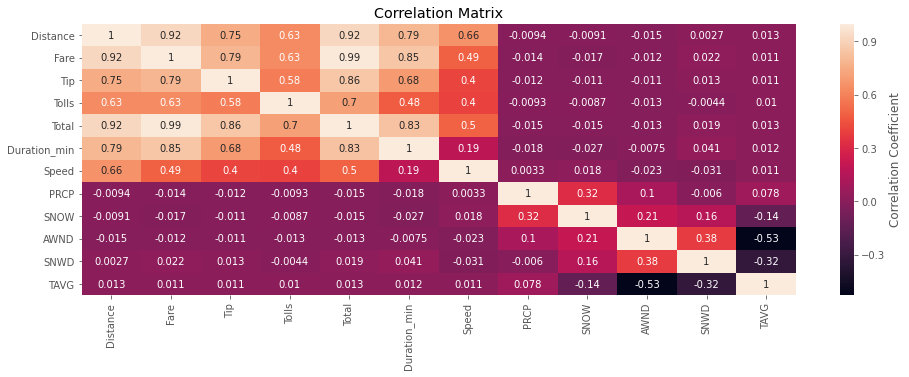

In [5]:
col = ['trip_distance', 'fare_amount', 'tip_amount','tolls_amount', 'total_amount', 'duration_min', 'trip_speed_mph', 'PRCP', 'SNOW', 'AWND', 'SNWD', 'TAVG']
label = ['Distance', 'Fare', 'Tip', 'Tolls','Total', 'Duration_min', 'Speed', 'PRCP', 'SNOW', 'AWND', 'SNWD', 'TAVG']

# plot correlation plot
fig, ax = plt.subplots(figsize=(16, 5))
corr_matrix = data[col].corr()
sns.heatmap(corr_matrix, annot=True, ax=ax, cbar_kws={'label': 'Correlation Coefficient'})
ax.set_xticklabels(label)
ax.set_yticklabels(label)
ax.set_title("Correlation Matrix")
plt.show()

## Data sampling

Since the dataset is too large and we are not working distributed, we will use samples again.

In [5]:
# Again we have to select a sample for modelization, but lower than the sampling for visualization.
sample = data.sample(n=500000, replace=True, random_state=303).reset_index(drop=True)

In [7]:
#sample.to_pickle('\..\Data\processed\sample_w_500k.pkl')

## EXPLORATION MODELS

##### Linear regression, Decision Tree, Random Forest, XGB 
To create a benchmark of models, we want to use metodologies more traditionals like linear Regression and other ML techniques to see how is better in this problem. We will use other models like Decision Tree, and Random Forest, to evaluate the metrics of all of them and choose the model with the best performance.

We want to use an gradient boosting algotithm. Between gbt and xgbt, we will use xgboost because it's use a more regularized model formalization to control over-fitting, which gives it better performance.

In [126]:
sample = pd.read_pickle('\..\Data\processed\sample_w_500k.pkl')

In [127]:
data_m = sample[['trip_distance', 'fare_amount', 'tip_amount','tolls_amount', 
                       'duration_min', 'trip_speed_mph', 'PRCP', 'SNOW', 'AWND', 'SNWD', 'TAVG']]

X = data_m.drop(["tip_amount"], axis=1).to_numpy()
y = data_m["tip_amount"].to_numpy()

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X =scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Train: " + str(len(X_train)))
print("Test: " + str(len(X_test)))

Train: 400000
Test: 100000


In [128]:
models = {"LR":LinearRegression(),
         "DT":DecisionTreeRegressor(),
         "RF":RandomForestRegressor(),
         "XGBT":XGBRegressor()
         }

In [129]:
for name,model in models.items():
    print(f'Model:{name}')
    model.fit(X_train,y_train)
    print(f'training score:{round(model.score(X_train, y_train) * 100, 2)}')
    print(f'test score:{round(model.score(X_test,y_test)*100,2)}')
    y_pred =model.predict(X_test)
    print(f'RMSE:{np.sqrt(mean_squared_error(y_test,y_pred))}')
    print(' ')

Model:LR
training score:62.7
test score:65.64
RMSE:1.5291039621601317
 
Model:DT
training score:99.9
test score:31.95
RMSE:2.151959378468002
 
Model:RF
training score:92.41
test score:61.06
RMSE:1.6278213605544842
 
Model:XGBT
training score:73.36
test score:66.04
RMSE:1.520280169396067
 


In [133]:
filename = '\..\Models\tip_amount_estimator.sav'
pickle.dump(models['XGBT'], open(filename, 'wb'))

The candidate models would be a linear regression and the XGBT. Because the others by overfitting lose all the power of prediction.

We see that although there is overfitting in the train, the XGBT is the algorithm that presents the highest goodness of fit (R2), and a smaller RSME, so we would select it. However the performance is quite poor overall, it may be because the dataset has a large range between the largest and smallest observed values.

### Models with Categorical Data

In [116]:
sample = pd.read_pickle('\..\Data\processed\sample_w_500k.pkl')

In [117]:
import geopandas as gpd
# taxi zone shapefile from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
sf_zones = gpd.read_file('\..\Data\external\taxi_zones.shp')
zone = pd.read_csv('\..\Data\external\taxi_zone_lookup.csv')

# Coordinate Reference Systems
sf_zones['geometry'] = sf_zones['geometry'].to_crs('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
sf_zones['lon'] = sf_zones.centroid.x
sf_zones['lat'] = sf_zones.centroid.y

In [118]:
sample_zones = pd.merge(sample, sf_zones, left_on='PULocationID', right_on='LocationID')
sample_zones = pd.merge(sample_zones, sf_zones, left_on='DOLocationID', right_on='LocationID')

In [119]:
sample_zones.rename(columns = {'geometry_x':'geometry_pu', 'geometry_y':'geometry_do', 
                              'lon_x':'lon_pu', 'lon_y':'lon_do',
                              'lat_x':'lat_pu', 'lat_y':'lat_do',
                              'zone_x':'zone_pu', 'zone_y':'zone_do',
                              'OBJECTID_x':'OBJECTID_pu', 'OBJECTID_y':'OBJECTID_do',
                              'LocationID_x':'LocationID_pu', 'LocationID_y':'LocationID_do',
                              'borough_x':'borough_pu', 'borough_y':'borough_do',
                              'Shape_Leng_x':'Shape_Leng_pu', 'Shape_Leng_y':'Shape_Leng_do',
                              'Shape_Area_x':'Shape_Area_pu', 'Shape_Area_y':'Shape_Area_do' }, inplace = True)

In [120]:
def part_dat(row):
    if (row >= 5) & (row <= 12):
        val = "morning"
    elif (row > 12) & (row <= 17):
        val = "afternoon"
    elif (row > 17) & (row <= 21):
        val = "evening"
    else:
        val = "night"
    return val

sample_zones['part_day'] = sample_zones['pickup_hour'].apply(part_dat)

In [121]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2017-01-01', end='2017-11-30')

sample_zones['date'] = sample_zones['tpep_pickup_datetime'].dt.normalize()
sample_zones['holiday'] = sample_zones['date'].isin(holidays)

sample_zones.loc[sample_zones['holiday'] == True, 'day_type'] = "holiday"
sample_zones = sample_zones.drop(['holiday'], axis=1)
sample_zones.loc[sample_zones['pickup_weekday_num'] >= 5, 'day_type'] = "weekend"
sample_zones.loc[sample_zones['pickup_weekday_num'] < 5, 'day_type'] = "workday"

In [122]:
data_m = sample_zones[['trip_distance', 'fare_amount', 'tip_amount','tolls_amount', 
                       'duration_min', 'trip_speed_mph', 'PRCP', 'SNOW', 'AWND', 'SNWD', 'TAVG',
                       'day_type','part_day']]

from sklearn.preprocessing import LabelEncoder
data_m =data_m.apply(LabelEncoder().fit_transform)

In [123]:
X = data_m.drop(["tip_amount"], axis=1).to_numpy()
y = data_m["tip_amount"].to_numpy()

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("Train: " + str(len(X_train)))
print("Test: " + str(len(X_test)))

Train: 392753
Test: 98189


## Model exploration

In [83]:
models = {"LR":LinearRegression(),
         "DT":DecisionTreeRegressor(),
         "RF":RandomForestRegressor(),
         "XGBT":XGBRegressor()}

In [84]:
for name,model in models.items():
    print(f'Model:{name}')
    model.fit(X_train,y_train)
    print(f'training score:{round(model.score(X_train, y_train) * 100, 2)}')
    print(f'test score:{round(model.score(X_test,y_test)*100,2)}')
    y_pred =model.predict(X_test)
    print(f'RMSE:{np.sqrt(mean_squared_error(y_test,y_pred))}')
    print(' ')

Model:LR
training score:70.11
test score:69.57
RMSE:122.04087795372652
 
Model:DT
training score:99.97
test score:40.65
RMSE:170.42913527612393
 
Model:RF
training score:94.03
test score:65.78
RMSE:129.4051310666424
 
Model:XGBT
training score:74.8
test score:69.95
RMSE:121.27146524998712
 


Again we see how the performance of the best model is that of the XGBT, however the lowest RMSE is that of the Linear regression. In addition, this error has increased with respect to the previous test in which we did not have categorical variables. This is because one of the difficulties with R-squared is that it can only increase as predictors are added to the regression model. This increase is artificial when the predictors do not improve the fit of the model.

To increase the performance of the model we can produce the residual plots and see the heteroscedasticity in the residuals by fitted values plot.

If we detect heteroscedasticity, we can apply some techniques to reduce it, such as redefining the variables, for example, recalculating the target as the percentage of tips with respect to the total trip.

## Turn the model in to an API.

To put the model into production through an API, once the model is trained we save it (cloud service or local).
From there we would have to build a web service with a tool like Flask or FastAPI (native python), depending on the use that is going to be given. Depending on the use that the client is going to give it, a more powerful or less powerful web service would be needed, depending on the number of requests they want to make per minute, security levels that are needed for the service, etc.

As a final step, the API should be tested with a service such as Postman to see that it meets the needs that have been previously defined by the client.